# Artigo base

O [artigo](./olaniyi2015.pdf) aborda o problema da alta incidência de doenças cardíacas, que resultam em um número significativo de mortes anualmente, especialmente nos Estados Unidos, onde cerca de 800.000 pessoas morrem de doenças cardíacas a cada ano. Além disso, muitas pessoas vivem com doenças cardíacas sem saber, o que as torna ainda mais perigosas, sendo chamadas de "assassinos silenciosos". Fatores de risco como tabagismo, dieta inadequada e pressão arterial alta aumentam as chances de desenvolver essas doenças. Devido ao risco elevado de diagnósticos errados, o artigo enfatiza a necessidade de sistemas inteligentes para diagnosticar doenças cardíacas com alta precisão, utilizando redes neurais artificiais como uma solução promissora para prevenir diagnósticos equivocados.

# O dataset

O dataset utilizado no artigo é o [Cleveland Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease), que  14 atributos, sendo 13 atributos preditivos e um atributo de classe. Os atributos preditivos são:

| Variable Name | Role    | Type         | Demographic | Description                                       | Units  | Missing Values |
|---------------|---------|--------------|-------------|---------------------------------------------------|--------|----------------|
| age           | Feature | Integer      | Age         |                                                   | years  | no             |
| sex           | Feature | Categorical  | Sex         |                                                   |        | no             |
| cp            | Feature | Categorical  |             |                                                   |        | no             |
| trestbps      | Feature | Integer      |             | resting blood pressure (on admission to the hospital) | mm Hg  | no             |
| chol          | Feature | Integer      |             | serum cholestoral                                 | mg/dl  | no             |
| fbs           | Feature | Categorical  |             | fasting blood sugar > 120 mg/dl                   |        | no             |
| restecg       | Feature | Categorical  |             |                                                   |        | no             |
| thalach       | Feature | Integer      |             | maximum heart rate achieved                       |        | no             |
| exang         | Feature | Categorical  |             | exercise induced angina                           |        | no             |
| oldpeak       | Feature | Integer      |             | ST depression induced by exercise relative to rest |        | no             |


In [16]:
from typing import Dict, Callable, Union, Iterable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import seaborn as sns

# Constants
num_experiments = 1000

# Juntandos os dados em um único DataFrame

In [17]:
def get_data_gathered(cities: list[str] = ['cleveland'], save: bool = False) -> pd.DataFrame:
    columns = [
        'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
    ]

    def load_data(file_path: str) -> pd.DataFrame:
        df = pd.read_csv(file_path, header=None, names=columns, na_values='?')
        return df

    files: list[str] = [f'./data/processed.{city}.data' for city in cities]

    result_df = pd.concat([load_data(file)
                          for file in files], ignore_index=True)
    if save:

        output_path = f'./data/heart_disease_{"_".join(cities)}.csv'
        result_df.to_csv(output_path, index=False)
        print(f"Arquivo CSV criado com sucesso em: {output_path}")

    return result_df

# Pré processamento dos dados

Foram implementadas 2 alternativas para teste, uma em que os valores nulos são preenchidos, e outra em que os valores nulos são removidos.

In [18]:
def deal_with_nil(original_df: pd.DataFrame, drop_nulls: bool = True) -> pd.DataFrame:
    if drop_nulls:
        return original_df.dropna()

    df = original_df.copy()
    # Substitua lacunas para frente do valor válido anterior em: 'trestbps'
    df = df.fillna({'trestbps': df['trestbps'].ffill()})
    # Substitua os valores ausentes pela média de cada coluna em: 'chol'
    df = df.fillna({'chol': df['chol'].mean()})
    # Substitua as lacunas do próximo valor válido em: 'fbs'
    df = df.fillna({'fbs': df['fbs'].bfill()})
    # Substitua os valores ausentes pela média de cada coluna em: 'thalach'
    df = df.fillna({'thalach': df['thalach'].mean()})
    # Substitua os valores ausentes pelo modo de cada coluna em: 'restecg'
    df = df.fillna({'restecg': df['restecg'].mode()[0]})
    # Substitua os valores ausentes pelo modo de cada coluna em: 'exang'
    df = df.fillna({'exang': df['exang'].mode()[0]})
    # Remover coluna: 'ca' (muitos nulls)
    df = df.drop(columns=['ca'])
    # Substitua lacunas para frente do valor válido anterior em: 'slope'
    df = df.fillna({'slope': df['slope'].ffill()})
    # Substitua os valores ausentes pelo modo de cada coluna em: 'thal'
    df = df.fillna({'thal': df['thal'].mode()[0]})
    # Substitua lacunas para frente do valor válido anterior em: 'oldpeak'
    df = df.fillna({'oldpeak': df['oldpeak'].ffill()})
    return df

Para a normalização foi usado o MinMaxScaler, que transforma os dados para que fiquem entre 0 e 1. Transformando a coluna objetivo em 0 e 1. Onde 0 é saudável e 1 é doente, no banco de dados original os valores são [0..4], onde qualquer número >0 é não saudável.

![preprocessamento](./assets/pre-processing.png)

In [19]:
def normalize(original_df: pd.DataFrame) -> pd.DataFrame:
    df_clean = original_df.copy()
    print("Quantidade de classes nos dados limpos:")
    print(df_clean['num'].value_counts())

    df_clean['num'] = df_clean['num'].apply(
        lambda x: 0 if x == 0 else 1)

    scaler = MinMaxScaler()
    df_clean_normalized = df_clean.copy()
    df_clean_normalized = pd.DataFrame(scaler.fit_transform(
        df_clean_normalized), columns=df_clean_normalized.columns)

    df_clean_normalized.describe()

    df_clean_normalized['num'] = df_clean_normalized['num'].astype(bool)

    print("Quantidade de classes nos dados normalizados:")
    print(df_clean_normalized['num'].value_counts())

    return df_clean_normalized

In [20]:
df: pd.DataFrame = normalize(deal_with_nil(get_data_gathered()))

df.head()

Quantidade de classes nos dados limpos:
num
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64
Quantidade de classes nos dados normalizados:
num
False    160
True     137
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,0.708333,1.0,0.000000,0.481132,0.244292,1.0,1.0,0.603053,0.0,0.370968,1.0,0.000000,0.75,False
1,0.791667,1.0,1.000000,0.622642,0.365297,0.0,1.0,0.282443,1.0,0.241935,0.5,1.000000,0.00,True
2,0.791667,1.0,1.000000,0.245283,0.235160,0.0,1.0,0.442748,1.0,0.419355,0.5,0.666667,1.00,True
3,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.0,0.885496,0.0,0.564516,1.0,0.000000,0.00,False
4,0.250000,0.0,0.333333,0.339623,0.178082,0.0,1.0,0.770992,0.0,0.225806,0.0,0.000000,0.00,False


# Replicando a arquitetura do artigo

Parametros do melhor modelo encontrado no artigo:

![best parameters](./assets/best_params.png)


In [21]:
X = df.drop('num', axis=1)
y = df['num']

## Dividindo em treino e teste 60:40
Foi feito assim como no artigo

*"The dataset was divided using ratio 60:40 i.e. 60% of the 2015 International Conference on Advances in Biomedical Engineering (ICABME) 22 dataset for training and 40% of the dataset for testing of the network. This is the standard ratio for dividing dataset in machine learning datase"*

In [22]:
# Divide o dataset em 60% treino e 40% teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

# Exibe os tamanhos dos conjuntos de treino e teste
print(f'Tamanho do conjunto de treino: {X_train.shape[0]}')
print(f'Tamanho do conjunto de teste: {X_test.shape[0]}')

Tamanho do conjunto de treino: 178
Tamanho do conjunto de teste: 119


## Treinamento do modelo

Para implementação da rede neural retropropagada foi utilizado o scikit-learn, que possui um [pacote de rede neural retropropagada](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#mlp-tips)

Os resultados publicados no artigo é que o modelo implementado (MLP) obteve uma acurácia de 85%, que é maior que os resultados obtidos com outros modelos de classificação, porem o resultado obtido foi de 73%, importante notar que este resultado é encontrado ao definir a semente como 42, ao executar o código com outras sementes o resultado pode variar como demonstrado mais abaixo:

![resultados](./assets/comparison.png)

Matriz de Confusão:
[[48 12]
 [20 39]]
Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.71      0.80      0.75        60
        True       0.76      0.66      0.71        59

    accuracy                           0.73       119
   macro avg       0.74      0.73      0.73       119
weighted avg       0.74      0.73      0.73       119



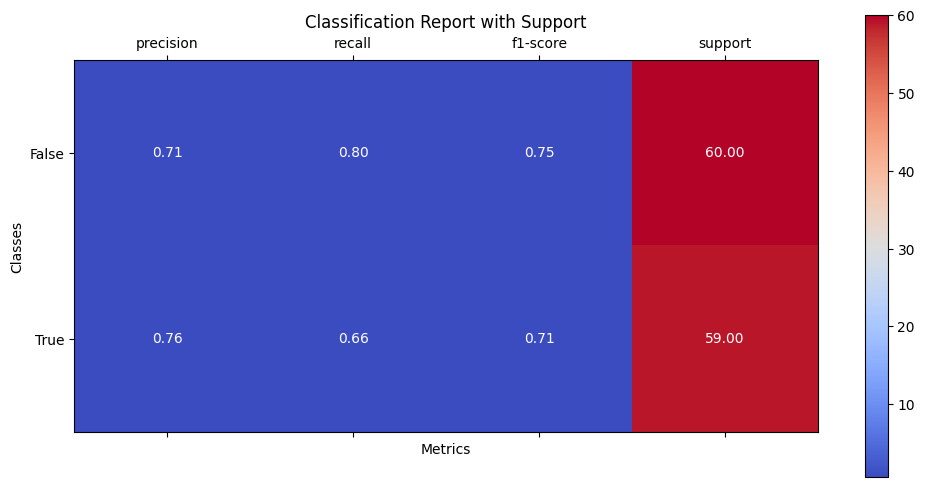

F1-Score: 0.7090909090909091
Score: 0.7310924369747899


In [23]:
np.random.seed(42)
model_60_40 = MLPClassifier(hidden_layer_sizes=(
    6,), max_iter=2000, learning_rate_init=0.32, momentum=0.72, activation='logistic')

model_60_40.fit(X_train, y_train)
score = model_60_40.score(X_test, y_test)

y_pred = model_60_40.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusão:')
print(conf_matrix)

cr = classification_report(y_test, y_pred)
print('Relatório de Classificação:')
print(cr)


def plot_classification_report_with_support(report):
    # Exclude 'accuracy', 'macro avg', 'weighted avg'
    labels = list(report.keys())[:-3]
    metrics = ['precision', 'recall', 'f1-score', 'support']
    data = np.array([[report[label][metric]
                    for metric in metrics] for label in labels])
    _, ax = plt.subplots(figsize=(12, 6))
    cax = ax.matshow(data, cmap='coolwarm')
    plt.xticks(range(len(metrics)), metrics)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar(cax)
    for (i, j), val in np.ndenumerate(data):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.title('Classification Report with Support')
    plt.show()


# Plotting the classification report with support
plot_classification_report_with_support(
    classification_report(y_test, y_pred, output_dict=True)
)
print(f'F1-Score: {f1_score(y_test, y_pred)}')
print(f"Score: {score}")

## Plotando a matriz de confusão

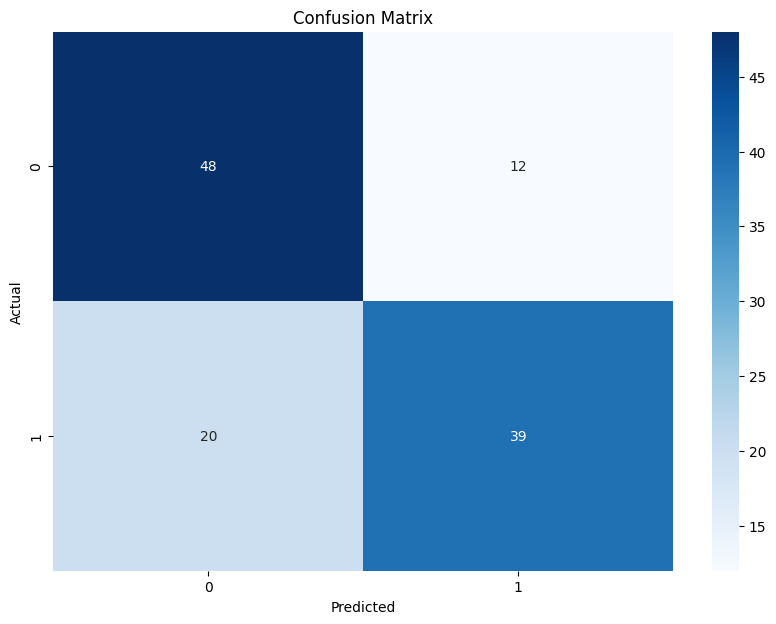

In [24]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Experimentos realizados

Para padronizar os experimentos foi criado um framework que recebe quais parâmetros devem ser testados e retorna a média e desvio padrão dos resultados obtidos.
Para cada variação de parâmetros, foram coletados dados de 1000 execuções, onde a semente de geração de números aleatórios foi alterada a cada execução de acordo com o número da execução $[0..1000)$

Para cada experimento foi coletada a média de acurácia dentre as 1000 execuções, e foi plotado um gráfico onde no eixo x está o parâmetro variado e no eixo y linhas representando a acurácia média, minima, máxima, e desvio padrão.

In [25]:
ExperimentType = Callable[[Union[str, int]], np.float64]
ExperimentResults = Dict[Union[str, int], Dict[str, np.float64]]


def experiment_runner(param_range: Iterable, experiment: ExperimentType, set_seed: bool = True) -> ExperimentResults:
    """
        Run experiments with different parameters and return the best parameter, best score, and standard deviation.
        Args:
            param_range (Iterable): A range of parameters to be tested.
            experiment (ExperimentType): A function that takes a parameter and returns a score.
        Returns:
            (Tuple[Tuple[Union[str, int], np.float64], np.float64]): A tuple containing the best parameter, best score, and standard deviation.
    """
    over_all_results: ExperimentResults = {param: {} for param in param_range}
    for param in param_range:  # Para cada parametro que está sendo variado
        param_results = []
        # Executa o experimento num_experiments (1000) vezes
        for seed in range(num_experiments):
            if set_seed:
                np.random.seed(seed)  # define a semente aleatória
            # executa o experimento e recebe a acurácia
            score = experiment(param)
            param_results.append(score)

        over_all_results[param]['mean'] = np.mean(param_results)
        over_all_results[param]['std_dev'] = np.std(param_results)
        over_all_results[param]['max'] = np.max(param_results)
        over_all_results[param]['min'] = np.min(param_results)
    return over_all_results


def plot_experiment_results(results: ExperimentResults, x_label: str, y_label: str, title: str):
    """
        Plot the results of an experiment.
        Args:
            results (ExperimentResults): The results of the experiment.
            x_label (str): The label for the x-axis.
            y_label (str): The label for the y-axis.
            title (str): The title of the plot.
    """
    x = list(results.keys())
    y_mean = [results[param]['mean'] for param in x]
    y_std_dev = [results[param]['std_dev'] for param in x]
    y_max = [results[param]['max'] for param in x]
    y_min = [results[param]['min'] for param in x]

    plt.errorbar(x, y_mean, yerr=y_std_dev, fmt='o-',
                 capsize=5, label='Mean ± Std Dev')
    plt.plot(x, y_max, 'g--', label='Max')
    plt.plot(x, y_min, 'r--', label='Min')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

## Primeira modificação: K Fold

Nesta modificação iremos usar **kfold** com [2..20] splits ao invés de dividir em 60:40.

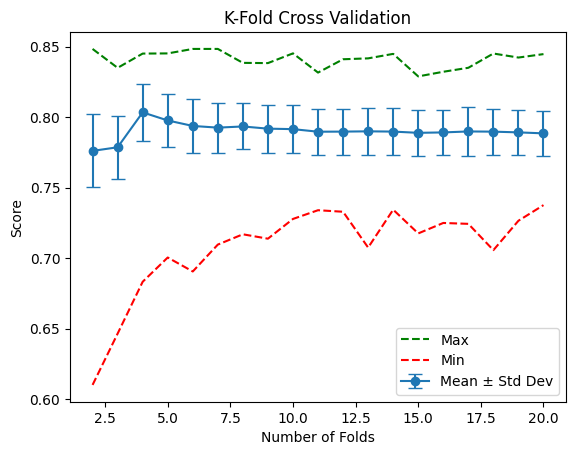

In [26]:
def k_fold_experiment(n_folds: Union[int, str]) -> np.float64:
    assert isinstance(n_folds, int)
    kf = KFold(n_splits=n_folds, shuffle=True)

    model_kfold = MLPClassifier(hidden_layer_sizes=(
        6,), max_iter=2000, learning_rate_init=0.32, momentum=0.72, activation='logistic')

    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_kfold.fit(X_train, y_train)
        score = model_kfold.score(X_test, y_test)
        scores.append(score)

    return np.mean(scores)


plot_experiment_results(
    experiment_runner(range(2, 21), k_fold_experiment),
    'Number of Folds',
    'Score',
    'K-Fold Cross Validation'
)

## Segunda modificação: Épocas

Aqui variamos o número de épocas da arquitetura original.

O número de épocas foi variado de 400 a 3000 com passo de 200.

/home/yurih/ufu/ic/heart-disease-ann/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/yurih/ufu/ic/heart-disease-ann/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/yurih/ufu/ic/heart-disease-ann/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/yurih/ufu/ic/heart-disease-ann/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimiza

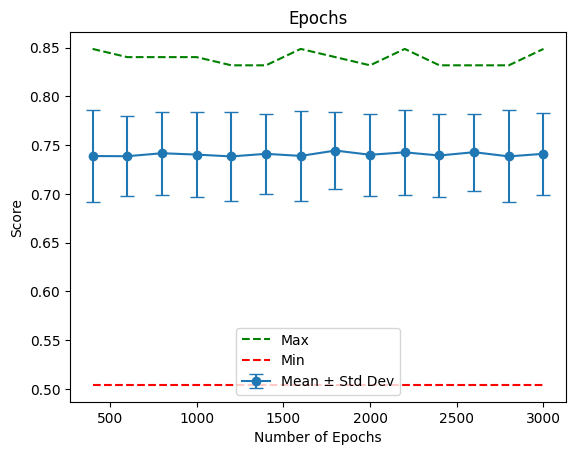

In [27]:
def epoch_experiment(epochs: Union[int, str]) -> np.float64:
    assert isinstance(epochs, int)
    model_60_40 = MLPClassifier(hidden_layer_sizes=(
        6,), max_iter=epochs, learning_rate_init=0.32, momentum=0.72, activation='logistic')

    model_60_40.fit(X_train, y_train)
    return np.float64(model_60_40.score(X_test, y_test))


plot_experiment_results(
    experiment_runner(range(400, 3001, 200), epoch_experiment, set_seed=False),
    'Number of Epochs',
    'Score',
    'Epochs'
)

### Usando seeds

Ao definir a seed como nos outros experimentos, notamos que o número de épocas não afeta o resultado do modelo, como é possível ver no gráfico abaixo.

/home/yurih/ufu/ic/heart-disease-ann/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/yurih/ufu/ic/heart-disease-ann/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/yurih/ufu/ic/heart-disease-ann/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/yurih/ufu/ic/heart-disease-ann/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimiza

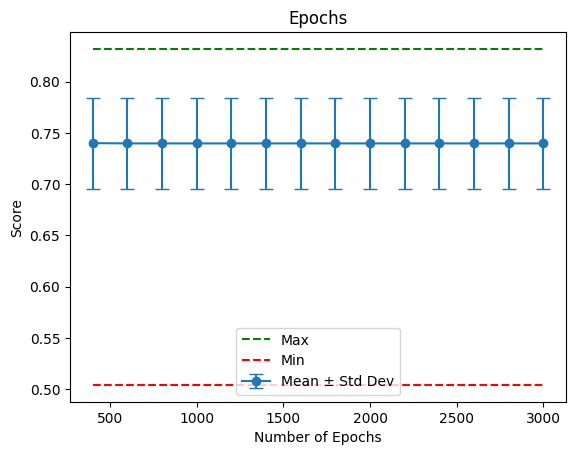

In [28]:
plot_experiment_results(
    experiment_runner(range(400, 3001, 200), epoch_experiment, set_seed=True),
    'Number of Epochs',
    'Score',
    'Epochs'
)

## Terceira Modificação: Função de Ativação

Aqui testamos a arquitetura original com todas as funções de ativação disponíveis no sklearn (relu, identity, tanh, logistic).

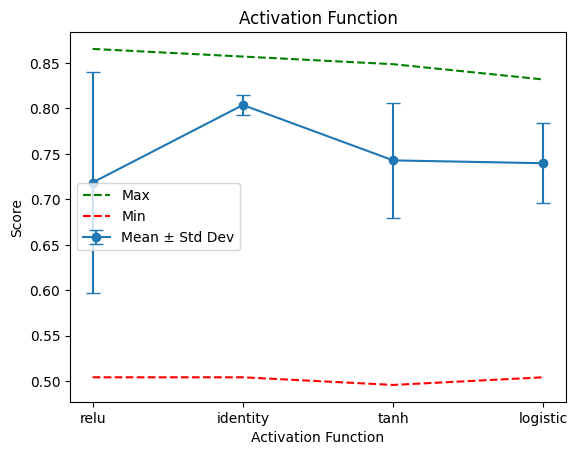

In [29]:
def activation_function_experiment(activation: Union[str, int]) -> np.float64:
    assert isinstance(activation, str)
    assert activation in ['relu', 'identity', 'tanh', 'logistic']
    model_60_40 = MLPClassifier(hidden_layer_sizes=(
        6,), max_iter=2000, learning_rate_init=0.32, momentum=0.72, activation=activation)  # type: ignore

    model_60_40.fit(X_train, y_train)
    return np.float64(model_60_40.score(X_test, y_test))


plot_experiment_results(
    experiment_runner(['relu', 'identity', 'tanh', 'logistic'],
                      activation_function_experiment),
    'Activation Function',
    'Score',
    'Activation Function'
)

## Quarta Moficação: Número de Neurônios

No artigo foram usados 6 neurônios na camada oculta, aqui testamos com 2, 4, 6, 8, 10, 12, 14, 16, 18, 20.

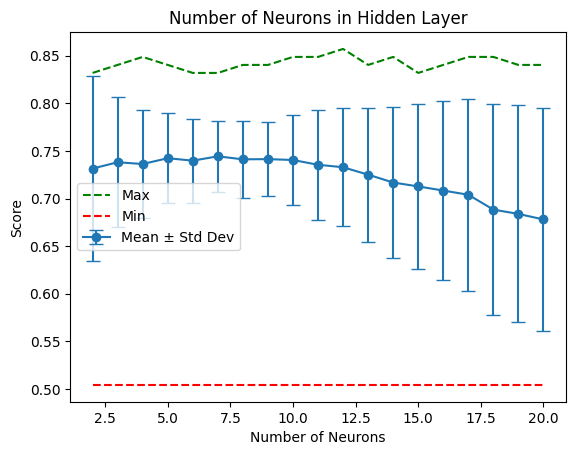

In [30]:
def num_neurons_experiment(number_of_neurons: Union[str, int]) -> np.float64:
    assert isinstance(number_of_neurons, int)
    model_60_40 = MLPClassifier(hidden_layer_sizes=(
        number_of_neurons,), max_iter=2000, learning_rate_init=0.32, momentum=0.72, activation='logistic')

    model_60_40.fit(X_train, y_train)
    return np.float64(model_60_40.score(X_test, y_test))


plot_experiment_results(
    experiment_runner(range(2, 21), num_neurons_experiment),
    'Number of Neurons',
    'Score',
    'Number of Neurons in Hidden Layer'
)

# Conclusão

O modelo implementado obteve uma acurácia de 73%, que é menor que os 85% obtidos no artigo, porem ao testar de forma mais robusta, definindo as sementes de geração de números aleatórios, foi possível observar que algumas variações de parâmetros os resultados obtidos foram ligeralmente melhores nos melhores casos, e piores na média. A falta de informação sobre a semente de geração de números aleatórios pode ter influenciado nos resultados obtidos no artigo, e dificultou a replicação dos resultados.